In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import constants as con
import pandas as pd
import pickle

import sys, os
from pathlib import Path

'''
sys.path.insert(0, "/home/canada/munich_pmt_calibration_system/QE_setup/")
from devices.Picoamp_6485 import Picoamp_6485_0
from devices.Picoamp_6485 import Picoamp_6485_1
from devices.PSU import PSU2
'''

repo_root = Path.cwd()
save_dir_path = repo_root / "SAT_calibration.pkl"
print(save_dir_path)

#Picoscope import not working here -> use Saturation.ipynb in omcu!

/home/josef/Documents/Master/Masterarbeit/OMCU_masters_project/SAT_calibration.pkl


In [10]:
np.mean(Picoamp_6485_1.Instance().read(2))

-3.6237035e-12

In [33]:
current_f=[]

In [ ]:
#Calibration with POCAM flasher
voltage=np.linspace(3,20,18)
current=[]
sipm=[]

PSU2.Instance().on()
for volt in voltage:
    PSU2.Instance().settings(1,volt)
    current.append(np.mean(Picoamp_6485_1.Instance().read(2)))
    print(volt,":",current[-1])
PSU2.Instance().off() 
current_f.append(current)
print("Done")

3.0 : -3.1853235e-12
4.0 : -5.1444745e-12
5.0 : -8.141954500000001e-12
6.0 : -1.0483105e-11
7.0 : -1.276857e-11
8.0 : -1.4479799999999999e-11
9.0 : -1.6011285e-11
10.0 : -1.7410425e-11
11.0 : -1.851907e-11
12.0 : -1.9276519999999998e-11
13.0 : -2.0277065e-11
14.0 : -2.085426e-11
15.0 : -2.13381e-11
16.0 : -2.186596e-11
17.0 : -2.2060330000000002e-11
18.0 : -2.2278965e-11
19.0 : -2.2441095e-11
20.0 : -2.230321e-11
Done


In [112]:
current_f=[[-1.557052e-12, -1.824314e-12, -1.8929415000000003e-12, -2.262942e-12, -2.457184e-12, -2.6858415e-12, -3.001613e-12, -3.240994e-12, -3.5664655e-12, -3.6638919999999996e-12, -3.794814e-12, -3.9797615e-12, -4.079536000000001e-12, -4.304211e-12, -4.4868085e-12, -4.4958955e-12], [-1.9362275000000003e-12, -2.2909065e-12, -2.9896445e-12, -3.5073145e-12, -3.9071315e-12, -4.4728e-12, -4.955031e-12, -5.249967e-12, -5.691655e-12, -6.220356e-12, -6.6704155e-12, -6.8992725e-12, -6.97372e-12, -7.352294e-12, -7.7982705e-12, -8.122925e-12],[ -2.2807575000000002e-12, -3.0061685e-12, -3.983629e-12, -4.772662e-12, -5.5009295000000006e-12, -6.1412635e-12, -6.8127435e-12, -7.488207e-12, -8.082376000000001e-12, -8.803795000000001e-12, -9.132636000000001e-12, -9.8000235e-12, -1.038255e-11, -1.051541e-11, -1.1262659999999999e-11, -1.144311e-11]]

In [38]:
# Example measurement key and list of measurements
measurement_key = "PD+filter"  # "10cm_SiPM" "20cm_SiPM" "45deg_PD" "90deg_PD" "direct_PD"

# Load existing data if file exists, otherwise start with an empty dict
if os.path.exists(save_dir_path):
    with open(save_dir_path, "rb") as f:
        measurements = pickle.load(f)
else:
    measurements = {}

# Ensure the key exists, then append your new measurement list
if measurement_key not in measurements:
    measurements[measurement_key] = []

measurements[measurement_key] = [current_f]

# Save the updated dictionary
with open(save_dir_path, "wb") as f:
    pickle.dump(measurements, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"{measurement_key} 'Saved in file'")

PD+filter 'Saved in file'


In [36]:
print(np.array(loaded_data["PD+filter"]).shape)

(1, 3, 18)


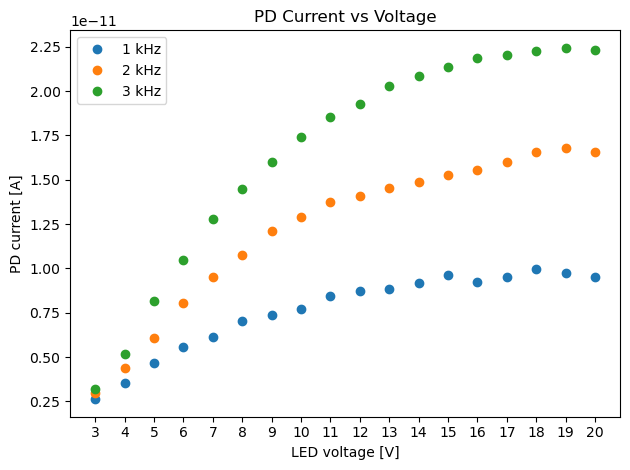

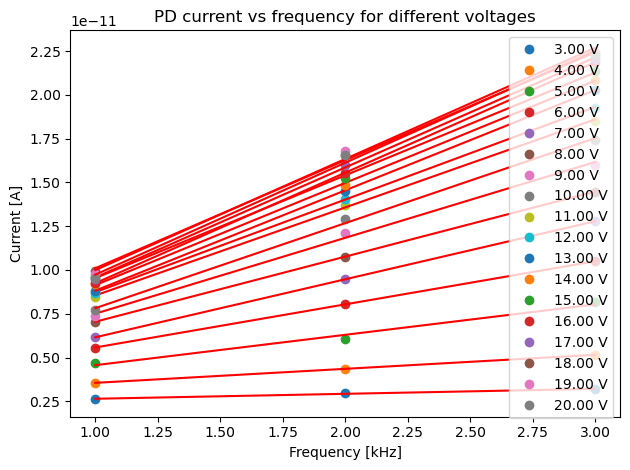

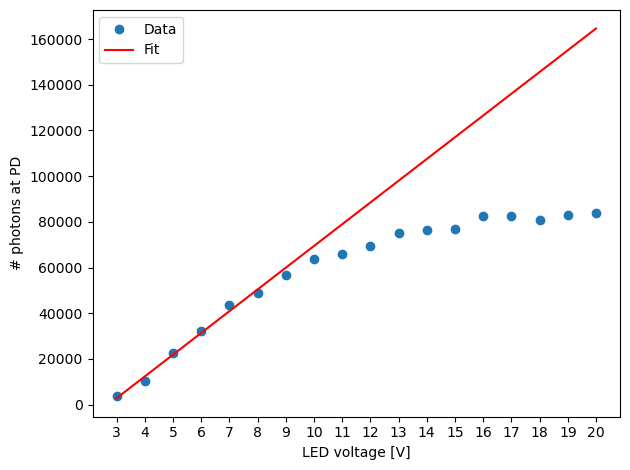

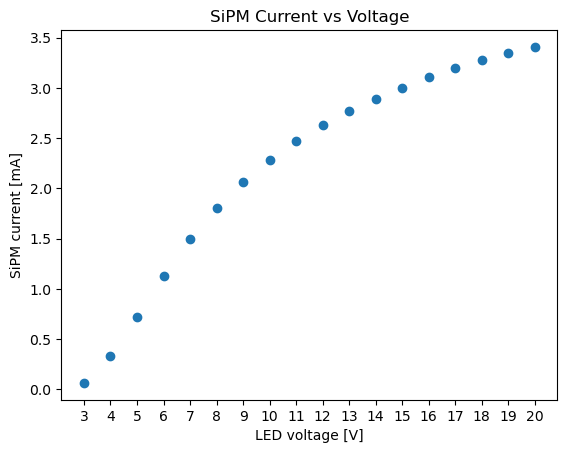

Slope: 27638.904839251012 Intercept: 1880.9272340408534 at 0.35mA: 11554.543927778706


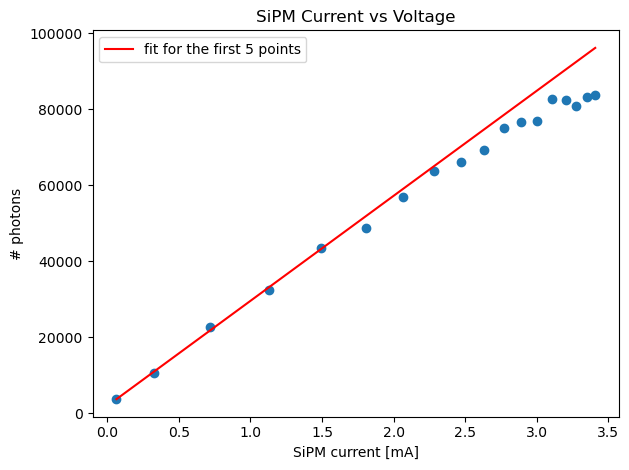

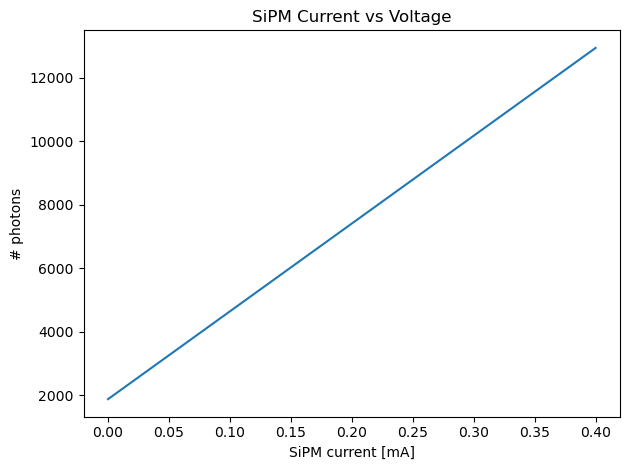

In [46]:
#NUMBER OF PHOTONS FROM THE SIPM
# --- load data ---
with open(save_dir_path, "rb") as file:
    loaded_data = pickle.load(file)
freq=[1,2,3]
voltage=np.linspace(3,20,18)

sipm_current=np.array(loaded_data["SiPM"])[0]
pd_currents=-np.array(loaded_data["PD+filter"]).transpose()
slopes=[]
# --- Plot PD Current vs Voltage ---
y = -np.array(loaded_data["PD+filter"])[0]
for i, freq_val in enumerate(freq):
    plt.plot(voltage, y[i,:],"o", label=f"{freq_val} kHz")
plt.title("PD Current vs Voltage")
plt.xlabel("LED voltage [V]"); plt.ylabel("PD current [A]")
plt.xticks(voltage)
plt.legend(); plt.tight_layout(); plt.show()

# --- Plot Voltage vs Frequency ---
for i,v in enumerate(voltage):
    y=pd_currents[i,:]
    slope, intercept, *_ = stats.linregress(freq, y.flatten()) 
    slopes.append(slope * 1e-3)  # convert slope A/kHz → A/Hz
    plt.plot(freq, y, "o", label=f"{v:.2f} V")
    plt.plot(freq, slope*np.array(freq)+intercept, "r")
plt.title("PD current vs frequency for different voltages")
plt.xlabel("Frequency [kHz]"); plt.ylabel("Current [A]")
plt.legend(); plt.tight_layout(); plt.show()

# --- Photons vs voltage ---
R, lam = 0.1401, 365e-9
photons = np.array(slopes) * lam / (R * con.c * con.h)
photons_angle.append(photons)
fit = np.polyfit(voltage[:3], photons[:3], 1)
plt.plot(voltage, photons, "o", label="Data")
plt.plot(voltage, np.polyval(fit, voltage), "r", label="Fit")
plt.xlabel("LED voltage [V]"); plt.ylabel("# photons at PD")
plt.xticks(voltage)
plt.legend(); plt.tight_layout(); plt.show()

# --- Plot SiPM Current vs Voltage
plt.plot(voltage,sipm_current,"o")
plt.title("SiPM Current vs Voltage")
plt.xlabel("LED voltage [V]"); plt.ylabel("SiPM current [mA]")
plt.xticks(voltage)
plt.show()

# --- Plot #Photons SiPM Current + fit
plt.plot(sipm_current, photons,"o")
slope, intercept, *_ = stats.linregress(sipm_current[:5], photons[:5])
print("Slope:",slope,"Intercept:",intercept, "at 0.35mA:",slope*0.35+intercept)
plt.plot(sipm_current, slope*sipm_current+intercept, "r", label="fit for the first 5 points")
plt.title("SiPM Current vs Voltage")
plt.xlabel("SiPM current [mA]"); plt.ylabel("# photons")
plt.legend(); plt.tight_layout(); plt.show()

# --- Plot for our Range ---
rang=np.arange(0,0.41,0.1)
plt.plot(rang,slope*rang+intercept)
plt.title("SiPM Current vs Voltage")
plt.xlabel("SiPM current [mA]"); plt.ylabel("# photons")
plt.tight_layout(); plt.show()


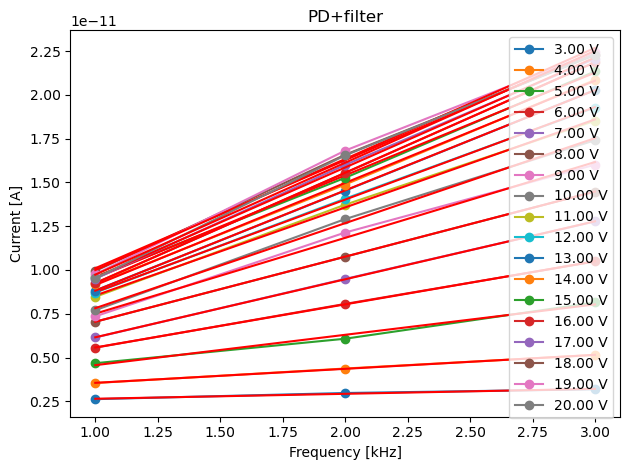

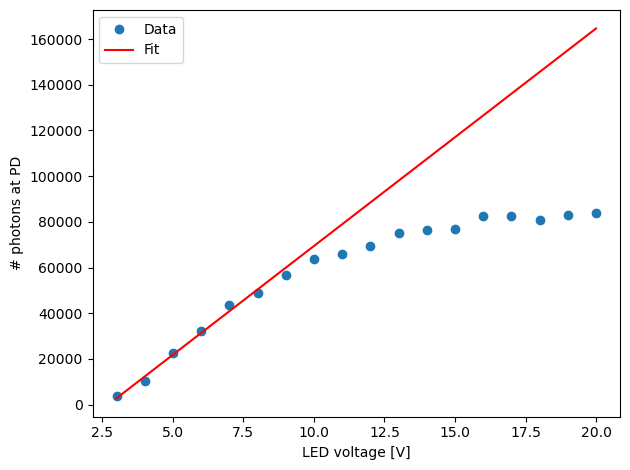

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 1

In [ ]:
# --- Load data ---
with open(save_dir_path, "rb") as file:
    loaded_data = pickle.load(file)

measurements = ["PD+filter","SiPM"]
freq=[1,2,3]
voltage=np.linspace(3,20,18)
photons_angle=[]

for meas in measurements:
    if meas not in loaded_data:
        print(f"Missing key: {meas}")
        continue

    data_t=-np.array(loaded_data[meas]).transpose()
    slopes=[]
    # --- Plot currents & fit slopes ---
    for i, v in enumerate(voltage):
        y = data_t[i]
        slope, intercept, *_ = stats.linregress(freq, y.flatten()) 
        slopes.append(slope * 1e-3)  # convert slope A/kHz → A/Hz
        plt.plot(freq, y, "o-", label=f"{v:.2f} V")
        plt.plot(freq, slope*np.array(freq)+intercept, "r")
    plt.title(meas)
    plt.xlabel("Frequency [kHz]"); plt.ylabel("Current [A]")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- Photons vs voltage ---
    R, lam = 0.1401, 365e-9
    photons = np.array(slopes) * lam / (R * con.c * con.h)
    photons_angle.append(photons)
    fit = np.polyfit(voltage[:3], photons[:3], 1)
    plt.plot(voltage, photons, "o", label="Data")
    plt.plot(voltage, np.polyval(fit, voltage), "r", label="Fit")
    plt.xlabel("LED voltage [V]"); plt.ylabel("# photons at PD")
    plt.legend(); plt.tight_layout(); plt.show()


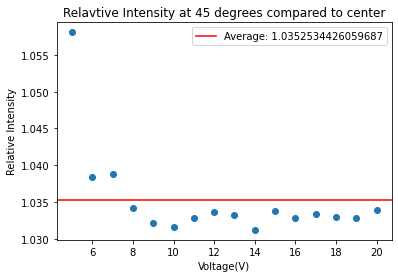

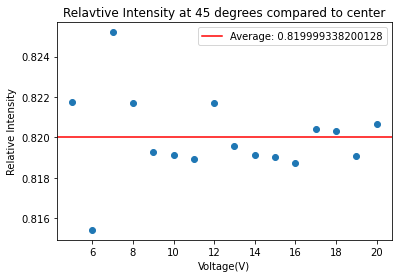

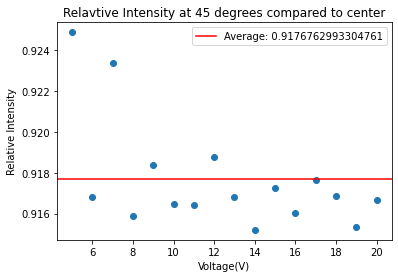

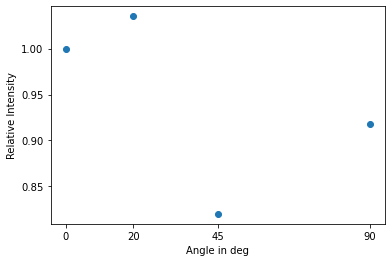

In [99]:
angle=[0,20,45,90]
avgs=[1]
for a in range(len(angle)-1):
    ratio=photons_angle[a+1]/photons_angle[0]
    avg=np.mean(ratio)
    avgs.append(avg)
    plt.plot(voltage, ratio,"o",linestyle="None")
    plt.axhline(avg,color="red",label=f"Average: {avg}")
    plt.legend()
    plt.title("Relavtive Intensity at 45 degrees compared to center")
    plt.xlabel("Voltage(V)")
    plt.ylabel("Relative Intensity")
    plt.show()

plt.plot(angle,avgs,"o",linestyle="None")
plt.xlabel("Angle in deg")
plt.xticks(angle)
plt.ylabel("Relative Intensity")
plt.show()

In [24]:
#voltage=np.linspace(3.86,9,7)
voltage_list=[np.linspace(5,9,5),np.linspace(5,20,11)]
#f=[90,100,115]
f=[80,90,100]
#data=-np.array([[1.6771050000000014e-14, 2.7367490000000004e-13, -3.20994e-13, -3.2559980000000003e-13, -1.265249e-13, -5.441248000000001e-13, -1.5400250000000002e-12, -1.6372615e-12], [-1.986817e-13, -2.462765e-13, -6.1935375e-13, -1.5113645e-12, -3.744205e-12, -4.1050005e-12, -4.8378504999999995e-12, -5.567122e-12], [2.2454730000000002e-13, -3.3557724999999998e-12, -1.1538414999999999e-11, -2.0922185e-11, -3.0512685e-11, -4.050189e-11, -4.749366e-11, -5.5808794999999995e-11], [-6.3214745e-13, -4.4576034999999995e-12, -1.720828e-11, -3.12532e-11, -4.5123605e-11, -5.815676e-11, -7.082401999999999e-11, -8.216574000000001e-11], [-7.708358999999999e-13, -5.528731e-12, -2.2159605e-11, -4.0254665e-11, -5.771972e-11, -7.470987e-11, -9.035554499999999e-11, -1.0574595e-10]])
data=-np.array([[-2.4197525e-12, -9.814697e-12, -1.8168655e-11, -2.6548805e-11, -3.4564119999999995e-11, -4.2139990000000003e-11, -4.9495049999999996e-11], [-2.6220919999999997e-12, -1.0813630000000001e-11, -2.025611e-11, -2.9420165e-11, -3.813329e-11, -4.671438e-11, -5.4709635e-11], [-3.0815625000000003e-12, -1.2496125e-11, -2.3017915e-11, -3.3493825e-11, -4.3819885e-11, -5.3305545e-11, -6.2751315e-11]])
data=[[[-9.32755e-09, -1.53615e-08, -2.1024499999999997e-08, -2.6207450000000002e-08, -3.0897920000000004e-08], [-1.0542400000000001e-08, -1.7410215e-08, -2.3935435e-08, -2.998196e-08, -3.5494465000000006e-08], [-1.1743395e-08, -1.9376765e-08, -2.6617835e-08, -3.3325905e-08, -3.945166e-08]],[[-2.3503534999999999e-07, -5.099566500000001e-07, -7.7110575e-07, -1.0139225e-06, -1.2382435e-06, -1.4444679999999999e-06, -1.634326e-06, -1.8081105e-06, -1.9631355000000003e-06, -2.1002455e-06, -2.2253695e-06], [-2.6339415e-07, -5.71292e-07, -8.636627500000001e-07, -1.1355559999999998e-06, -1.3865269999999999e-06, -1.6169965e-06, -1.8290525e-06, -2.0225745e-06, -2.194459e-06, -2.3463525e-06, -2.4852035e-06], [-2.9195495e-07, -6.333058e-07, -9.570264999999999e-07, -1.2578629999999999e-06, -1.535106e-06, -1.789678e-06, -2.0237355000000002e-06, -2.2371175e-06, -2.4253435e-06, -2.5919685e-06, -2.7443965e-06]]]

voltage=np.linspace(5,20,16)
f=[1,2,3]
data=[[[-3.3760575e-08, -6.108819499999999e-08, -8.759291e-08, -1.1291495e-07, -1.3713895e-07, -1.603445e-07], [-1.6944765e-07, -3.05186e-07, -4.3704465e-07, -5.629584e-07, -6.832218e-07, -7.980758e-07], [-3.39894e-07, -6.1092785e-07, -8.7410105e-07, -1.125296e-06, -1.3648615e-06, -1.593245e-06]],[[-4.043006e-10, -5.339376e-10, -6.59918e-10, -7.7921085e-10, -8.936045e-10, -1.00332e-09], [-1.0681815e-09, -1.717366e-09, -2.344041e-09, -2.9418099999999998e-09, -3.511246e-09, -4.052919000000001e-09], [-1.8915375e-09, -3.186526e-09, -4.438339e-09, -5.6301425e-09, -6.765063e-09, -7.8400435e-09]]]
data=[[[-3.4218625e-08, -6.18303e-08, -8.8581245e-08, -1.141255e-07, -1.385471e-07, -1.619513e-07, -1.8434955e-07, -2.0576015e-07, -2.261662e-07, -2.4563859999999997e-07, -2.6421290000000005e-07, -2.819499e-07, -2.9877945e-07, -3.1458105e-07, -3.2935469999999997e-07, -3.4325960000000005e-07], [-6.863609500000001e-08, -1.235184e-07, -1.767248e-07, -2.2749374999999998e-07, -2.759918e-07, -3.2237735e-07, -3.66701e-07, -4.0898585e-07, -4.493241e-07, -4.877758e-07, -5.245393e-07, -5.595323e-07, -5.925250500000001e-07, -6.2334215e-07, -6.521958500000001e-07, -6.7942705e-07], [-1.029303e-07, -1.8502625e-07, -2.646163e-07, -3.405298e-07, -4.1296885e-07, -4.8221295e-07, -5.4832705e-07, -6.113277000000001e-07, -6.713505000000001e-07, -7.2861775e-07, -7.832445e-07, -8.352131499999999e-07, -8.8406935e-07, -9.295861499999999e-07, -9.7219575e-07, -1.012604e-06]]]


In [37]:
t=0.02
2.592808e-05*l/(R*con.c*con.h)*32e-9

10881739.703363668

m: 3.43558375e-08, c: -1.1666833333332609e-10
m: 6.159797500000001e-08, c: 2.6236666666666153e-10
m: 8.801752750000001e-08, c: 6.057266666666623e-10
m: 1.1320214999999999e-07, c: 9.787166666667049e-10
m: 1.37210875e-07, c: 1.4141666666666864e-09
m: 1.60130825e-07, c: 1.9188833333333303e-09
m: 1.8198874999999997e-07, c: 2.481700000000085e-09
m: 2.0278377500000006e-07, c: 3.1236833333332565e-09
m: 2.2259215000000003e-07, c: 3.76263333333335e-09
m: 2.41489575e-07, c: 4.364899999999955e-09
m: 2.595158e-07, c: 4.9673000000000236e-09
m: 2.76631625e-07, c: 5.635199999999995e-09
m: 2.9264495e-07, c: 6.5013833333334046e-09
m: 3.0750254999999995e-07, c: 7.498016666666741e-09
m: 3.2142052500000003e-07, c: 8.407716666666738e-09
m: 3.3467219999999995e-07, c: 9.085816666666758e-09


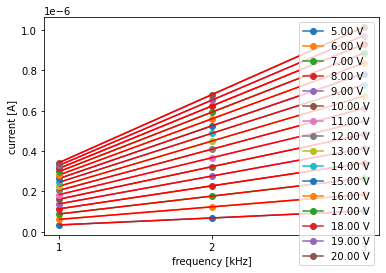

[4.50586875e+08 8.07875489e+08 1.15437566e+09 1.48467936e+09
 1.79956083e+09 2.10016269e+09 2.38683578e+09 2.65956862e+09
 2.91936126e+09 3.16720653e+09 3.40362575e+09 3.62810481e+09
 3.83812426e+09 4.03298604e+09 4.21552436e+09 4.38932396e+09]


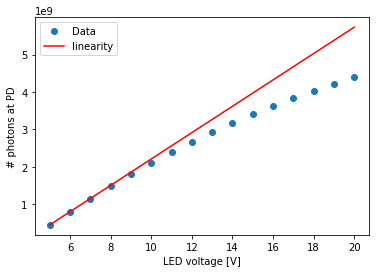

In [26]:
#Current vs frequency
for j in range(len(data)):
    data_t=-np.array(data[j]).transpose()
    #voltage=voltage_list[j]
    m_V=[]
    for i in range(len(voltage)):
        plt.plot(f,data_t[i],marker="o",label=f"{voltage[i]:.2f} V")

        #fit
        coeffs = stats.linregress(f[-3:], data_t[i][-3:])
        m=coeffs.slope
        c=coeffs.intercept
        print(f"m: {m}, c: {c}")
        y_fit=m*np.array(f)+c
        plt.plot(f,y_fit,color="red")
        m_V.append(m*1e-3) # convert slope A/kHz → A/Hz
    plt.legend()
    #plt.tight_layout()
    plt.xlabel("frequency [kHz]")
    plt.xticks(f)
    plt.ylabel("current [A]")
    plt.show()   

    #Number photons vs voltage
    R=0.1401
    l=365e-9
    #geo=16*(210/11.3)**2
    photons=np.array(m_V)*l/(R*con.c*con.h)
    
    # Linear fit using the first 3 points
    fit_coeffs = np.polyfit(voltage[:3], photons[:3], 1)
    fit_line = np.polyval(fit_coeffs, voltage)
    
    print(photons)
    plt.plot(voltage, photons, marker="o", linestyle="none", label="Data")
    plt.plot(voltage, fit_line, color="red", label=f"linearity")
    plt.xlabel("LED voltage [V]")
    plt.ylabel("# photons at PD")
    plt.legend()
    plt.show()


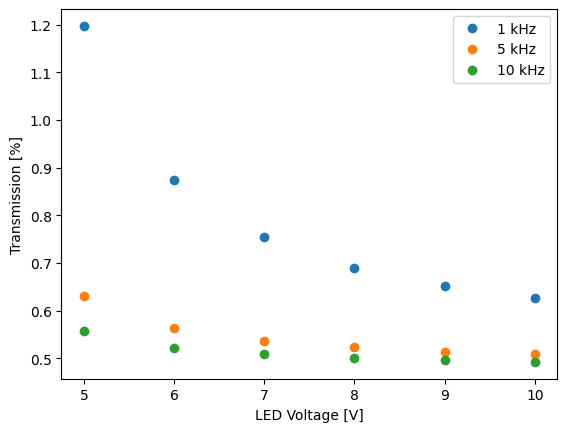

In [24]:
transm_fiber=np.array(data[1])/np.array(data[0])
for i in range(len(data[0])):
    plt.plot(voltage,transm_fiber[i]*100,"o",linestyle="None",label=f"{f[i]} kHz")
plt.legend()
plt.xlabel("LED Voltage [V]")
plt.ylabel("Transmission [%]")
plt.show()

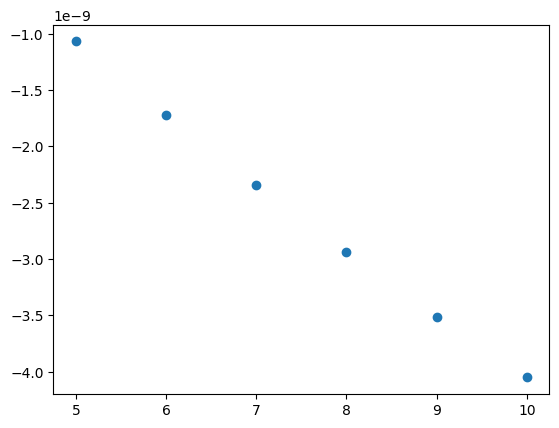

In [23]:
plt.plot(voltage,data[1][1],"o")

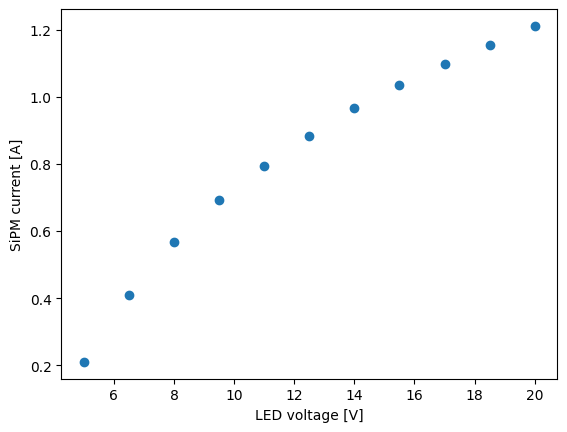

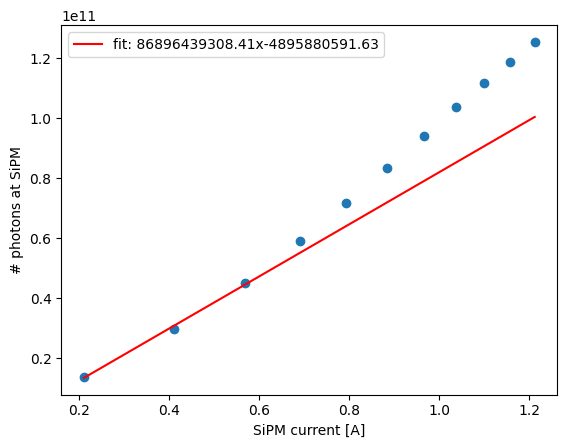

In [ ]:
#SiPM current vs Photons with Picoscope
current = np.array([0.20993701010704044, 0.4099149636077882, 0.5673637775802614, 0.6912189033813478, 0.7934645732879638, 0.8830551244812012, 0.9663181148223877, 1.0360755853881838, 1.0985858199005127, 1.1559684975280764, 1.2116598400115968])
#current/=2e-4
plt.plot(voltage_list[1],current,"o")
plt.ylabel("SiPM current [mA]")
plt.xlabel("LED voltage [V]")
plt.show()
area_ratio=6.07**2/100
photons_sipm=photons *area_ratio

coeff3 =stats.linregress(current[:3], photons_sipm[:3])
m, c = coeff3.slope,coeff3.intercept
N_curr=m*current+c

plt.plot(current, photons_sipm, marker="o", linestyle="None")
plt.plot(current,N_curr,color="red", label=f"fit: {m:.2f}x-{-c:.2f}")
plt.ylabel("# photons at SiPM")
plt.xlabel("SiPM current [mA]")
plt.legend()
plt.show()



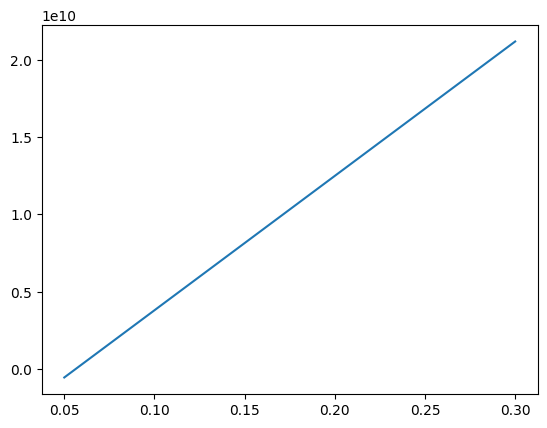

In [ ]:
x=np.array([0.05,0.3])
y=m*x+c

plt.plot(x,y)

100.28749148422018 0.368449


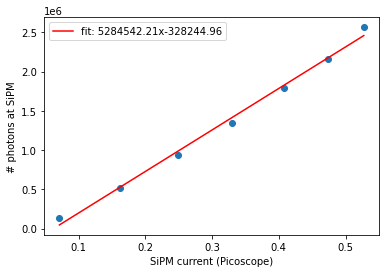

In [5]:
#SiPM current vs Photons with Picoscope
#current = np.array([0.022157479858398443, 0.07527559105396273, 0.16724409387588504, 0.2571338583946228, 0.3406141726875306, 0.41514960868835465, 0.48250393653869644, 0.539007871246338])
current = np.array([0.07097637817382813, 0.16157480245590214, 0.2494173239135743, 0.33020472288131714, 0.4078425223159792, 0.47302362312316903, 0.5273070835876467])
area_ratio=6.07**2/100
print((5.65**2*np.pi),area_ratio)
photons_sipm=photons *area_ratio


coeff3 = np.polyfit(current, photons_sipm, 1)
m, c = coeff3
N_curr=m*current+c

plt.plot(current, photons_sipm, marker="o", linestyle="None")
plt.plot(current,N_curr,color="red", label=f"fit: {m:.2f}x-{-c:.2f}")
plt.ylabel("# photons at SiPM")
plt.xlabel("SiPM current (Picoscope)")
plt.legend()
plt.show()

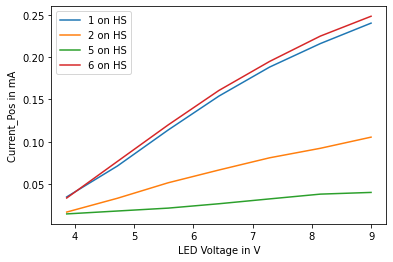

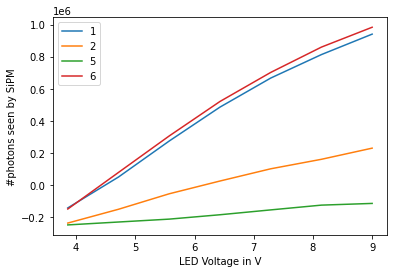

In [8]:
#positions
color=["tab:blue","tab:orange","tab:green","tab:red","purple"]
pos=[1,2,5,6]
#current_pos=np.array([[0.010661417081356053, 0.011921259572505952, 0.014125983932018284, 0.015511810672283176, 0.014598424866199496, 0.015212598080635074, 0.016897637412548072, 0.017669290938377387], [0.011763779261112215, 0.02820472398757935, 0.057795275571346304, 0.0855118123674393, 0.1124094502449036, 0.14062992073059086, 0.16031495985984803, 0.18154330716133124], [0.015055117769241337, 0.028393700397014627, 0.0632440944337845, 0.10045669490337375, 0.1299370077800751, 0.1605669283103943, 0.18355905533790592, 0.20377952949523934], [0.013307086312770845, 0.024472440485954292, 0.04760629937887194, 0.07267716560840609, 0.0960314979553223, 0.11965354408264163, 0.13595275521278385, 0.15270866055488588], [0.009055117905139924, 0.014440944554805761, 0.01752755865812302, 0.021196849954128273, 0.025133857817649846, 0.030409448456764233, 0.03338582652330399, 0.03845669296026231]])
#current_pos=np.array([[0.029700787003040317, 0.06166929132938387, 0.09466141928195955, 0.12488189015388493, 0.15113385736465457, 0.1764094487190247, 0.19888189152717595], [0.02171653499126435, 0.04425196868658067, 0.06955905524253848, 0.09149606468200686, 0.11288189107894903, 0.12725984265327459, 0.14467716456413274], [0.01319685009479523, 0.016062991764545443, 0.01870866099596024, 0.023889763295650488, 0.027291338152885446, 0.029086613836288456, 0.03251968481063844], [0.023826771192550666, 0.04762204743146897, 0.07192125998020174, 0.09451968694210054, 0.11500787513732914, 0.1326614170646668, 0.14853543249130252]])
current_pos=np.array([[0.03472440930604936, 0.07127559079170229, 0.11381102490425113, 0.15385826669692995, 0.18817322919845583, 0.2159370102596284, 0.2400944899177552], [0.016834645290374758, 0.03314960608482362, 0.05144881905555727, 0.06651968506097794, 0.08096063082218172, 0.09218897807121279, 0.1053700804805756], [0.01464566895961762, 0.018078739755153662, 0.02149606254816056, 0.02666141688108445, 0.03239370058298111, 0.03803149610042573, 0.04004724417686463], [0.03343307069301606, 0.07669291393280031, 0.11979527655601505, 0.16051968423843385, 0.19483464665412908, 0.22477165575027475, 0.2482362212562562]])



for i in range(len(pos)):
    plt.plot(voltage,current_pos[i],label=f"{pos[i]} on HS",color=color[i])
plt.xlabel("LED Voltage in V")
plt.ylabel("Current_Pos in mA")
plt.legend()
plt.show()



current_pos1=[]
geo2=6.07**2/4*np.pi*210**2
for i in range(len(pos)):
    #current_pos1.append(np.delete(current_pos[i], 0))
    N_pos=((m*current_pos[i]+c))
    plt.plot(voltage,N_pos,label=pos[i])
plt.xlabel("LED Voltage in V")
plt.ylabel("#photons seen by SiPM")
plt.legend()
plt.show()

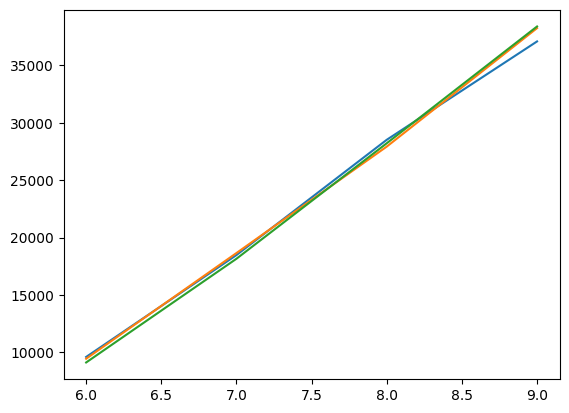

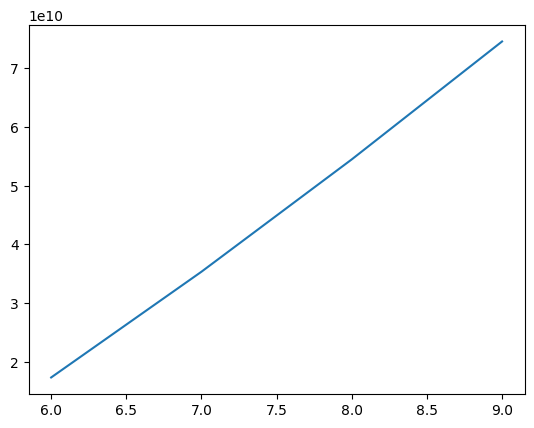

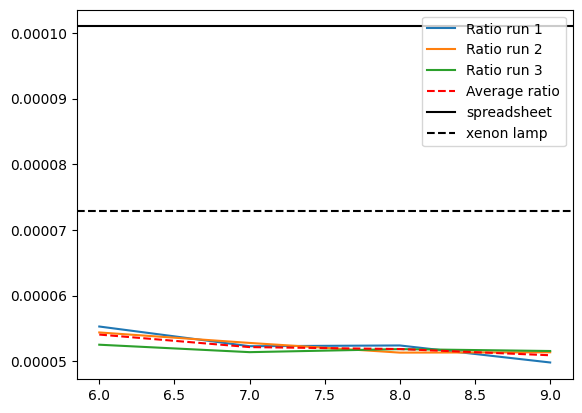

7.284600115559365e-05 vs. 1.010E-04


In [107]:
I=-np.array([[-1.5528195e-06, -3.157603e-06, -4.862413e-06, -6.651812e-06],
             [ -8.584080500000001e-13, -1.6507785e-12, -2.547555e-12, -3.31259e-12],
             [-8.4434025e-13, -1.6665595e-12, -2.49451e-12, -3.4160125e-12],
             [-8.153364e-13, -1.6221645e-12, -2.5205045e-12, -3.4288735e-12]])
v_2=np.linspace(6,9,4)
R=0.1821
l=405e-9
freq=1000
photons=[]
#calculate number of photons from current
for i in range(len(I)):
    photons.append(I[i]*l/(R*con.c*con.h*freq))
    
for i in range(len(I)-1):
    plt.plot(v_2,photons[i+1])
plt.show()
plt.plot(v_2,photons[0])
plt.show()
ratios = []
for i in range(1, len(I)):
    ratio = (I[i]/I[0])*100
    ratios.append(ratio)
    plt.plot(v_2, ratio, label=f'Ratio run {i}')

# Calculate and plot the average ratio
ratios = np.array(ratios)
avg_ratio = np.mean(ratios, axis=0)
plt.plot(v_2, avg_ratio, color='red', linestyle='--', label='Average ratio')
plt.axhline(1.010E-04,label="spreadsheet", color="black")
xenon = (1.0249935e-11/1.407069e-05)*100
plt.axhline(xenon,label="xenon lamp", color="black", linestyle="--")
plt.legend()
plt.show()
print(xenon,"vs. 1.010E-04")


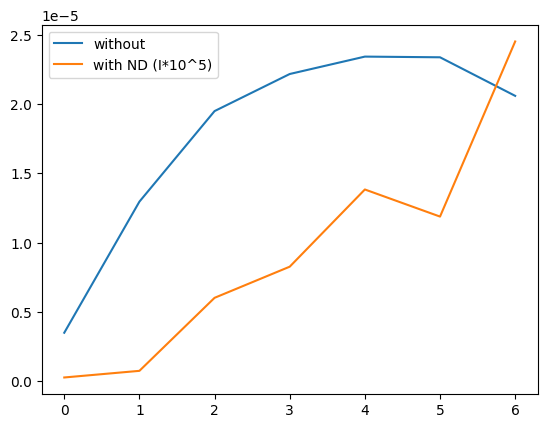

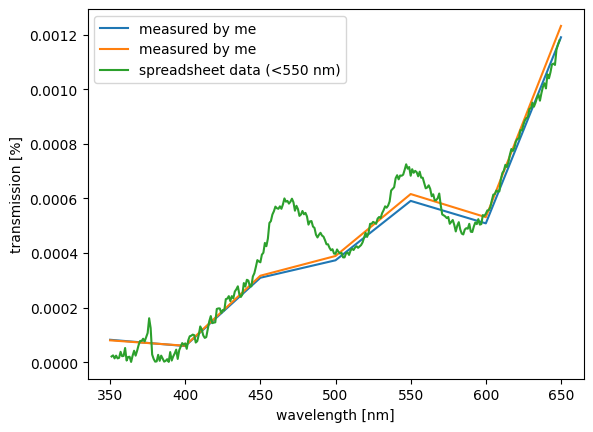

In [97]:
I=-np.array([[-3.5127454999999997e-06, -1.296174e-05, -1.9488244999999997e-05, -2.2160495e-05, -2.341448e-05, -2.3364935e-05, -2.058577e-05],
             [-2.8870675000000003e-12, -7.668951e-12, -6.029601999999999e-11, -8.2738545e-11, -1.3837815000000002e-10, -1.188447e-10, -2.4504675e-10],
             [-2.8144935e-12, -7.815908e-12, -6.173766e-11, -8.623342e-11, -1.4424245000000002e-10, -1.24124e-10, -2.5361165e-10]])
wl = np.arange(350,651,50)
df = np.array(pd.read_csv('C:/Users/Anwender/Documents/TUM/Masterarbeit/transmission_ND.csv')).transpose()

plt.plot(I[0],label="without")
plt.plot(I[1]*1e5, label="with ND (I*10^5)")
plt.legend()
plt.show()
for i in range(1,len(I)):
    ratio = (I[i]/I[0])*100
    plt.plot(wl,ratio,label="measured by me")

# Only plot spreadsheet data for df[0] < 550
mask = df[0] < 650
plt.plot(df[0][mask], df[1][mask], label="spreadsheet data (<550 nm)")
plt.xlabel("wavelength [nm]")
plt.ylabel("transmission [%]")
plt.legend()
plt.show()

<KeysViewHDF5 ['Light intensity 3.0', 'Light intensity 3.857142857142857', 'Light intensity 4.714285714285714', 'Light intensity 5.571428571428571', 'Light intensity 6.428571428571429', 'Light intensity 7.285714285714286', 'Light intensity 8.142857142857142', 'Light intensity 9.0']>


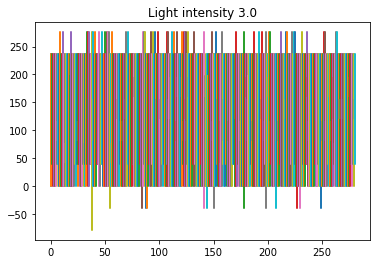

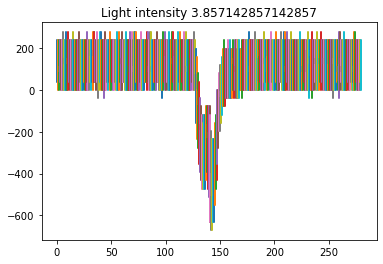

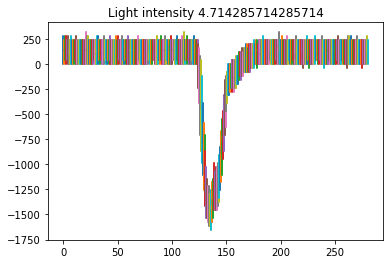

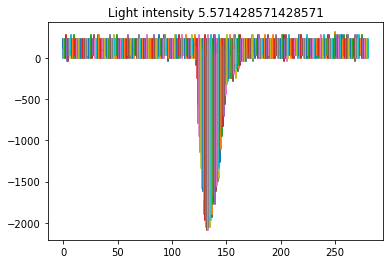

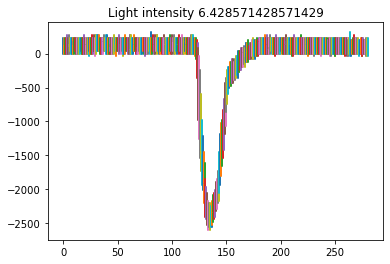

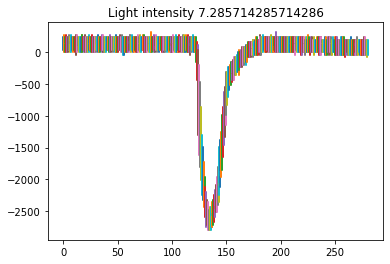

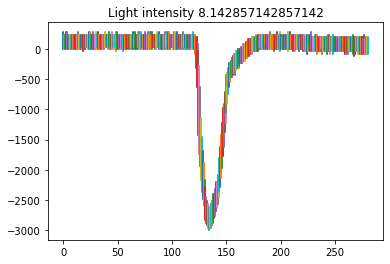

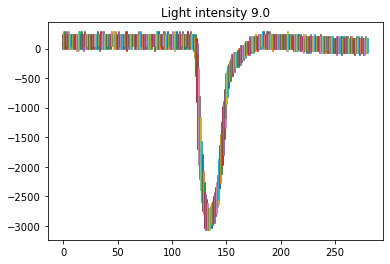

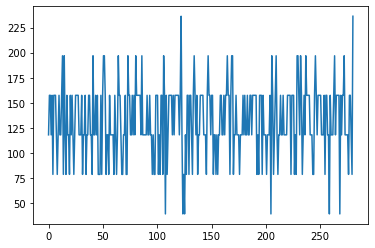

In [16]:
#checking waveforms for saturation measurement
import h5py
f = h5py.File('/mnt/HDD2/data/P-ONE-ONE/p-1-1-om-hs-33/SAT_POS_4_p-1-1-pmt-unit-KM55112_123/data_saturation_5000000.0.hdf5', 'r')
keys=f.keys()
print(keys)
for key in keys:
    dset=f[key]
    time=dset['dataset'][:,:,0]
    signal = dset['dataset'][:,:,1]
    plt.plot(time,signal)
    plt.title(key)
    plt.show()


In [ ]:
data=[np.array([ 5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,
        7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
        9.5 ,  9.75, 10.  ]), np.array([1.5952070e-12, 1.8842550e-12, 2.1581560e-12, 2.3263215e-12,
       2.7216130e-12, 3.0765775e-12, 3.2452565e-12, 3.6013460e-12,
       3.7502705e-12, 4.1556945e-12, 4.3065635e-12, 4.6594800e-12,
       4.9800525e-12, 5.1488320e-12, 5.4560990e-12, 5.7530275e-12,
       5.9682780e-12, 6.1725745e-12, 6.5307115e-12, 6.5909975e-12,
       6.8783055e-12]), np.array([7.0086840e-06, 7.4273925e-06, 7.8785165e-06, 8.0511650e-06,
       8.4188435e-06, 8.9054880e-06, 9.1151490e-06, 9.4644115e-06,
       9.6490780e-06, 1.0087590e-05, 1.0474480e-05, 1.0715855e-05,
       1.0960095e-05, 1.1438850e-05, 1.1674585e-05, 1.1916855e-05,
       1.2441170e-05, 1.2770135e-05, 1.2719125e-05, 1.3027085e-05,
       1.3517020e-05])]
#convert SiPM to milliAmps
data[2]*=1000